## Configuration 

In [28]:
import pandas as pd
import numpy as np

from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

data = '/Users/marco/Data Science/Data Science IV/LLM Pr/Final/diabetic_data.csv'
print("Imports and data ready")

Imports and data ready


## Load and clean data

In [27]:
df = pd.read_csv(data, low_memory = False)
print(df.shape)

columns = [
    "race", "gender", "age", "time_in_hospital",
    "num_lab_procedures", "num_procedures", "num_medications",
    "number_outpatient", "number_emergency", "number_inpatient",
    "number_diagnoses", "max_glu_serum", "A1Cresult",
    "insulin", "change", "diabetesMed",
    "readmitted"
]

df = df[columns].copy()

# Drop rows with missing values
df = df[df["readmitted"].notna()]

# 1 if readmitted <30 days, else 0 (Target variable to predict)
df["y"] = (df["readmitted"] == "<30").astype(int)

print("Target distribution:\n", df["y"].value_counts(normalize=True))
df.head()    

(101766, 50)
Target distribution:
 y
0    0.888401
1    0.111599
Name: proportion, dtype: float64


,race,gender,age,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,max_glu_serum,A1Cresult,insulin,change,diabetesMed,readmitted,y
0,Caucasian,Female,[0-10),1,41,0,1,0,0,0,1,NaN,NaN,No,No,No,NO,0
1,Caucasian,Female,[10-20),3,59,0,18,0,0,0,9,NaN,NaN,Up,Ch,Yes,>30,0
2,AfricanAmerican,Female,[20-30),2,11,5,13,2,0,1,6,NaN,NaN,No,No,Yes,NO,0
3,Caucasian,Male,[30-40),2,44,1,16,0,0,0,7,NaN,NaN,Up,Ch,Yes,NO,0
4,Caucasian,Male,[40-50),1,51,0,8,0,0,0,5,NaN,NaN,Steady,Ch,Yes,NO,0


## Define features. Train/test split

In [33]:
x = df.drop(columns=["y", "readmitted"]) # Info used for prediction (Input)
y = df["y"] # Target variable to predict (Output)

# Numeric and categorical features. Categorical to be encoded later.
num_cols = x.select_dtypes(include = ["int64", "float64"]).columns.tolist()
cat_cols = x.select_dtypes(include = ["object"]).columns.tolist()

print("Numeric:", num_cols)
print("Categorical:", cat_cols)

x_train, x_test, y_train, y_test = train_test_split(
    x, y,
    test_size = 0.2,  # 20% of the data into test, 80% into training
    random_state = 43, # 
    stratify = y  # Equal proportion of readmitted/not in tr/test
)

x_train.shape, x_test.shape


Numeric: ['time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses']
Categorical: ['race', 'gender', 'age', 'max_glu_serum', 'A1Cresult', 'insulin', 'change', 'diabetesMed']


((81412, 16), (20354, 16))

## Preprocessing and Log. Regression (model)

In [46]:
# OneHot for categorical, passthrough for numeric
proc = ColumnTransformer(
    transformers = [
        ("num", "passthrough", num_cols), # Num unchanged
        ("cat", OneHotEncoder(handle_unknown = "ignore"),
         cat_cols), # Each Cat becomes binary
    ])

# Log regression classifier
baseline_clf = LogisticRegression(
    max_iter = 1000, # Max steps to converge
    n_jobs = -1,)  # Use all CPU (faster)

baseline = Pipeline(steps = [
    ("preprocess", proc), ("clf", baseline_clf),
])

# Train and predict
baseline.fit(x_train, y_train)
y_pred = baseline.predict(x_test)

baseline

,steps,"[('preprocess', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


## Evaluate baseline

Baseline (Log.Reg) metrics:
  Accuracy : 0.888 (Overall correct predictions)
  Precision: 0.462 (Among predicted <30, how many <30)
  Recall   : 0.016 (Among true <30, how many caught)
  F1       : 0.031 (Harmonic mean of Prec/Recall)


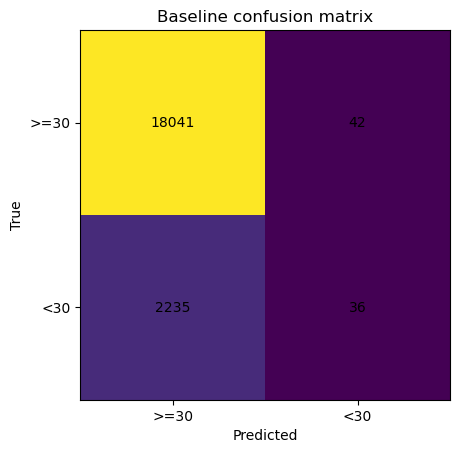

In [74]:
def metrics(y_true, y_pred, label = "Model"):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    print(f"{label} metrics:")
    print(f"  Accuracy : {acc:.3f} (Overall correct predictions)")
    print(f"  Precision: {prec:.3f} (Among predicted <30, how many <30)") 
    print(f"  Recall   : {rec:.3f} (Among true <30, how many caught)")
    print(f"  F1       : {f1:.3f} (Harmonic mean of Prec/Recall)")

metrics(y_test, y_pred, label="Baseline (Log.Reg)")

cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
fig, ax = plt.subplots()
im = ax.imshow(cm)
ax.set_xticks([0,1]); ax.set_yticks([0,1])
ax.set_xticklabels(["No <=30", "<30"]); ax.set_yticklabels(["No <=30", "<30"])
ax.set_xlabel("Predicted"); ax.set_ylabel("True")

for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha="center", va="center")

plt.title("Baseline confusion matrix")
plt.show()

Baseline model performed poorly on detecting 30-day readmissions due to high class imbalance.

Logistic Regression mostly predicts ‘no readmission’, resulting in high accuracy but extremely low recall.

We will train a random forest model with class balancing to improve predictive power.

## Fine-tuned model (Random Forest)

In [75]:
tuned_clf = RandomForestClassifier(
    n_estimators = 200,
    max_depth = None,
    min_samples_split = 10,
    class_weight = "balanced_subsample",
    random_state = 42,
    n_jobs = -1
)

tuned_pipe = Pipeline(steps = [
    ("preprocess", proc),
    ("clf", tuned_clf),
])

tuned_pipe.fit(x_train, y_train)
tuned_y_pred = tuned_pipe.predict(x_test)

metrics(y_test, tuned_y_pred, label = "Tuned (RandomForest)")

###cm_tuned = confusion_matrix(y_test, tuned_y_pred)
cm_tuned

Tuned (RandomForest) metrics:
  Accuracy : 0.880 (Overall correct predictions)
  Precision: 0.314 (Among predicted <30, how many <30)
  Recall   : 0.066 (Among true <30, how many caught)
  F1       : 0.109 (Harmonic mean of Prec/Recall)


array([[17757,   326],
       [ 2122,   149]])

In [72]:
##!!!!print(classification_report(y_test, tuned_y_pred, digits=3))

              precision    recall  f1-score   support

           0      0.893     0.982     0.936     18083
           1      0.314     0.066     0.109      2271

    accuracy                          0.880     20354
   macro avg      0.603     0.524     0.522     20354
weighted avg      0.829     0.880     0.843     20354



## Ollama set up for zero-shot classifier

In [88]:
from langchain_ollama import ChatOllama
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

llm = ChatOllama(model = "llama3.2", temperature=0)
prompt = ChatPromptTemplate.from_template(
    """You are helping a data scientist explain the prediction of a machine learning model.
This is research on hospital readmissions of diabetes patients. 
Do NOT give medical advice.

I will give you a short description of a patient stay and
the model's predicted probability of readmission within 30 days.

Patient description: {patient_text}

Model prediction: 
Probability of readmission within 30 days: {prob_30d:.2f}

Write 4-6 sentenes explaining:
Which features may increase or decrease risk. 
Why the model might assign this probability
Explain this is a data driven, non clinical assesment.
"""
) 

llm_chain = prompt | llm | StrOutputParser()

print("LLama explainer ready.")

LLama explainer ready.


In [99]:
# Turn rows into text, get predictions from LLM and evaluate
def row_to_text(row):
    """Build a short textual description of one patient stay
    using a subset of informative features."""
    return (
        f"Age group: {row['age']}. " 
        f"Gender: {row['gender']}. " 
        f"Time in hospital: {row['time_in_hospital']} days. " 
        f"Number of medications: {row['num_medications']}. "
        f"Number of lab procedures: {row['num_lab_procedures']}. "
        f"Number of inpatient visits in the past year: {row['number_inpatient']}. "
        f"Number of emergency visits in the past year: {row['number_emergency']}. "
        f"A1C result: {row['A1Cresult']}. "
        f"Max glucose serum: {row['max_glu_serum']}. "
        f"Insulin: {row['insulin']}. "
        f"Change in diabetes medication during stay: {row['change']}. "
        f"Any diabetes medication prescribed: {row['diabetesMed']}."
    )

In [100]:
import numpy as np

def explain_patient(idx = None):
    """
    Pick one patient from the test set, get RF prediction,
    and ask LLaMA to explain it in natural language.
    """

    if idx is None:
        idx = np.random.choice(x_test.index)
    row_x = x_test.loc[idx]
    true_y = y_test.loc[idx]

    # RF probability for <30
    prob = tuned_pipe.predict_proba(row_x.to_frame().T)[0, 1]
    # Test description
    patient_text = row_to_text(row_x)
    # Explanation LLama
    expl = llm_chain.invoke({
        "patient_text": patient_text,
        "prob_30d": prob})

    print("=== Patient ID:", idx, "===\n")
    print("True label (y):", int(true_y), "  (1 = readmitted <30 days)")
    print(f"Random Forest predicted probability of <30-day readmission: {prob:.3f}\n")
    print("Patient description:")
    print(patient_text, "\n")
    print("Model explanation (LLaMA):")
    print(expl)

explain_patient()

=== Patient ID: 82343 ===

True label (y): 0   (1 = readmitted <30 days)
Random Forest predicted probability of <30-day readmission: 0.230

Patient description:
Age group: [50-60). Gender: Male. Time in hospital: 2 days. Number of medications: 17. Number of lab procedures: 61. Number of inpatient visits in the past year: 1. Number of emergency visits in the past year: 0. A1C result: nan. Max glucose serum: nan. Insulin: Up. Change in diabetes medication during stay: Ch. Any diabetes medication prescribed: Yes. 

Model explanation (LLaMA):
Based on the patient description and model prediction, several features may contribute to the assigned probability of readmission within 30 days. The high number of medications (17) and lab procedures (61) may indicate complex medical management, which could increase the risk of readmission. Additionally, the recent history of inpatient visits (1) suggests that the patient's diabetes management may be challenging. However, the lack of emergency depart